Initializing and cleaning the [Credit Card Fraud Detection Dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv) from download directory that was downloaded from Kaggle. 

In [1]:
import pandas as pd
import numpy as np
#file path to credit card csv file
file_path = os.path.join(os.path.expanduser("~"), "Downloads", "creditcard.csv")
df = pd.read_csv(file_path) #read csv file as pandas object
CC_data = df.to_numpy() #CC_data will contain the Credit Card Fraud detection dataset as a numpy object
NaN_instances = []
#checking for NaN values in the dataset
for instance in CC_data:
    for datapoint in instance:
        if np.isnan(datapoint):
            NaN_instances.append(datapoint)
print(NaN_instances) #No NaN values so no need to clean up data

[]


# Isolation Tree
We will be using an isolation tree to detect anomalies in our Credit Card Fraud Detection Dataset. To do this, we will be following these steps: 

<strong>Isolation Tree Node:</strong>
- Define a isolation Tree Node for the building blocks of our isolation tree
- Will contain instance variables to keep track of depth, attributes, split values, leaf indicator and a left/right child

<strong>Isolation Tree:</strong>
- Define a tree that will recursively create our tree using our isolation tree node objects
- This will select a random feature from the dataset
- Given the random feature, our method will also randomly pick a split value within the proper range
- Then, we will partition our data into two subsets based on our feature and feature split value. All instances with feature values less than split value go to left child node, and the rest of the instances going right
- Keep partitioning and recursively creating nodes until max-depth is reached(most likely will reach max deoth) or all instances are split into leaves

<strong>Path Length Calculation:</strong>
- Create a method that will calculate the average path length from root to leaf. This average will represent the function c(n) with n being the number of leaf nodes.

<strong>Instance Depth Score:</strong>
- Given an instance, find the depth the instance travels down the isolation tree. This will represent the function h(x) with x representing the instance.

<strong>Anomaly Score Method:</strong>
- With c(n) representing the average path length from root to all leaves in a tree, and h(x) being the depth the instance travels down the isolation tree, we can use these to calculate an anomaly score. The formula we will be using is: S(x,n) = 2<sup>-(c(n)/h(x))</sup> 
- As you can see, if our instance is highly anamalous, the h(x) value will be small. This is because an anamalous instance will quickly split off homogenous instances which leads to a quick isolation of the anamalous instance, thus having a small depth. 
- The c(n) value will tend to be much higher than our h(x) value for anamalous instances because the average depth of an isolation tree should be large relative to the depth of an anamalous instance
- So if our h(x) is very low and our c(n) is very high, this should tell us that our instance is highly likely to be an anamoly. And as you can see, as h(x) decreases and c(n) increases, -(c(n)/h(x)) converge to -inf. So as this value converges to -inf, S(x,n) will converge to 0. This tells us that highly anamalous instances will be closer to the value 0, while a homogenous instance will be close to the value 1.








<strong>Isolation Tree Node</strong>

In [65]:
# first we define a tree-node type
class IsolationTreeNode:
    # constructor sets up members
    def __init__(self, isLeaf, attributeSplit, splitValue, curDepth):
        #indicates if node is a leaf this will happen if maxDepth is reached or there is only one instance in our dataset
        self.isLeaf = isLeaf 
        #the random attribute we are splitting on
        self.attributeSplit = attributeSplit
        #this will be a random value of the random random that will divide the data into two different sets
        self.splitValue = splitValue
        #current depth of the current node
        self.curDepth = curDepth
        self.left_child = None
        self.right_child = None
        
        

<strong>Isolation Tree</strong>
- Here we are defining an isolation tree class
- __init__ will intiliaze the models training data, the tree's maximum depth, and the root node for the tree
- createIsolationTree() will create the tree by recursively splitting the training data given a random feature and random split value. This will continue to create left and right nodes per split until a dataset is size 1 or if we've reached maximum depth. (returns root node)
- averageDepth() will average all the depths from root to all leaves, then return the average
- instanceDepth() will return the depth of a given instance
- anamolyScore() will return the anamoly score of a given instance. As stated before, we will use this formula S(x,n) = 2<sup>-(c(n)/h(x))</sup> to calculate the anamoly score

In [3]:
import random
class IsolationTree:
    def __init__(self, data, maxDepth):
        self.data = data #initialize data
        self.maxDepth = maxDepth #intialize max depth
        self.root = IsolationTreeNode(False, None, None, 0) #intialize root node
        
    def createIsolationTree(self, curDepth = None, data = None, node = None):
        #set variables to intialized values when we call
        curDepth = curDepth if curDepth is not None else 0
        data = data if data is not None else self.data
        node = node if node is not None else self.root
        #Base case is when we reach maximum desired depth or only one value in our dataset
        if curDepth == self.maxDepth or len(data) ==1:
            node.isLeaf = True
            return node
        #random feature selected by picking a random column index of data (data should not include labels)
        randFeature = random.randrange(len(data[0]))
        minFeatureValue = float('inf')
        maxFeatureValue = float('-inf')
        #finding min and max values of randomly chosen feature of all instances in the dataset
        for instance in data:
            minFeatureValue = min(minFeatureValue, instance[randFeature])
            maxFeatureValue = max(maxFeatureValue, instance[randFeature])
        #picking random split value within the bounds of the min and max feature value
        randSplitValue = random.uniform(minFeatureValue, maxFeatureValue)

        leftData = []
        rightData = []
        #append all instances with feature values greater than the split value to right data and vice verca
        for instance in data:
            if instance[randFeature]>randSplitValue:
                rightData.append(instance)
            else:
                leftData.append(instance)
        
        if not leftData or not rightData: #figure out what we should do about duplicates
            node.isLeaf = True
            return node
        
        leftData = np.array(leftData)
        rightData = np.array(rightData)
        node.attributeSplit = randFeature #indicate what attribute node split by
        node.splitValue = randSplitValue #indicate value node split the data by
        #recursively call for left and right child with left and right data
        node.left_child = self.createIsolationTree(curDepth+1, leftData, IsolationTreeNode(False, None, None, curDepth+1))
        node.right_child = self.createIsolationTree(curDepth+1, rightData, IsolationTreeNode(False, None, None, curDepth+1))
        if node == self.root:
            self.root = node
        return node
    #calculate average depth from root to all leaves
    def averageDepth(self, node = None, depthSum = [0 , 0]):
        node = node if node is not None else self.root
        if node.isLeaf:
            depthSum[0]+=node.curDepth #sum all the depths of leaves and store in 0th index
            depthSum[1]+=1 #accumulate number of leaves and store is 1st index
            return
        self.averageDepth(node.left_child, depthSum)
        self.averageDepth(node.right_child, depthSum)
        if node == self.root:
            return depthSum[0]/depthSum[1] #if root, we have found all leaves so return average
            
    #calculating the depth for the specific instance
    def instanceDepth(self, instance, node = None):
        node = node if node is not None else self.root
        #base case is when we encounte a leaf, here we will finally return the depth
        if node.isLeaf:
            return node.curDepth
        feature = node.attributeSplit
        splitValue = node.splitValue
        # if our feature value is greater than split value, go to right child, else, go to left child
        if instance[feature]>splitValue:
            x = self.instanceDepth(instance, node.right_child)
            return x
        else:
            y = self.instanceDepth(instance, node.left_child)
            return y
    def anamolyScore(self, instance):
        return 2**-(self.averageDepth()/self.instanceDepth(instance))
    

<strong>Isolation Forest</strong>
- __init__ will initialize the forest size, max depth, the number of features each tree will take in, and the percent of data each tree will contain
- createForest() will create each tree given a random subset of features and instances, and store the IsolationTree objects in an array
- averageDepth() will calculate the average depth of all average depths of the trees in the array
- instanceDepth() will calculate the average depth of an instance across all trees
- anamolyScore() will calculate the anomaly score given our instanceDepth() and averageDepth() method

In [1]:
class IsolationForest:
    def __init__(self, forestSize, maxDepth, numFeatures=.5, percentOfData = .2):
        self.forestSize = forestSize
        self.maxDepth = maxDepth
        self.numFeatures = .5
        self.forest = []
        self.percentOfData = percentOfData
        
    def createForest(self, data):
        forest = []
        for i in range(self.forestSize):
            random_indices = np.random.choice(data.shape[0], size=int(self.percentOfData*data.shape[0]), replace=True)
            tempData = data[random_indices]
            for i in range(len(tempData[0]) - int(self.numFeatures*len(data[0]))):
                randFeature = random.randrange(len(tempData[0]))
                tempData = np.delete(tempData, randFeature, 1)    
            tree = IsolationTree(tempData, self.maxDepth)
            tree.createIsolationTree()
            forest.append(tree)
        self.forest = forest
    def averageDepth(self):
        if not self.forest:
            print("Please create forest")
            return
        totalDepth = 0
        for tree in self.forest:
            totalDepth+=tree.averageDepth()
        return totalDepth/len(self.forest)
    def averageInstanceDepth(self, instance):
        if not self.forest:
            print("Please create forest")
            return
        totalInstanceDepth = 0
        for tree in self.forest:
            totalInstanceDepth+=tree.instanceDepth(instance)
        return totalInstanceDepth/len(self.forest)
    def anamolyScore(self, instance):
        return 2**-(self.averageDepth()/self.averageInstanceDepth(instance))

<strong>Testing</strong>
- First, we randomly sample data from our dataset then remove the labels so we can pass it to our isolation forest (unsupervised learning so labels not needed)
- We then created a forest with the number of tree being 100, maximum depth being 50, number of features being 20, and the percent of data for each tree being 30%
- We then randomly sample for our testing set
- We then run anamolyScore() for each instance of our testing set and store the anamoly scores in 'anamolyScores'
- we then plot a histogram of our anamoly scores, and we see that the anamoly scores follow a normal distribution
- We also plot a Q-Q plot to confirm that our anamoly scores follow a normal distribution
- Because our scores follow a normal distribution, we can use z-scores to indicate how much of a anamoly score is an outlier

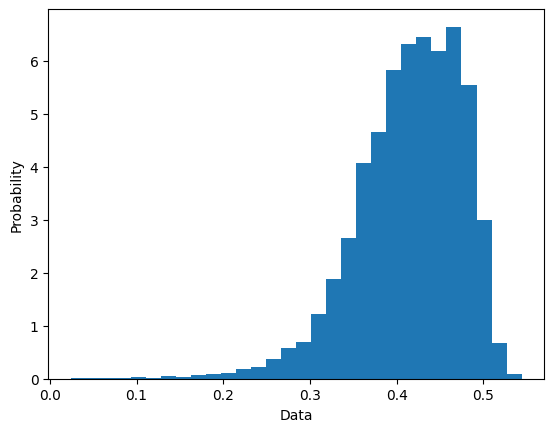

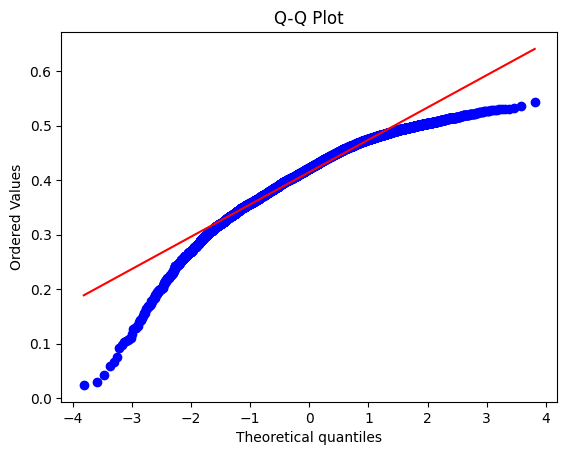

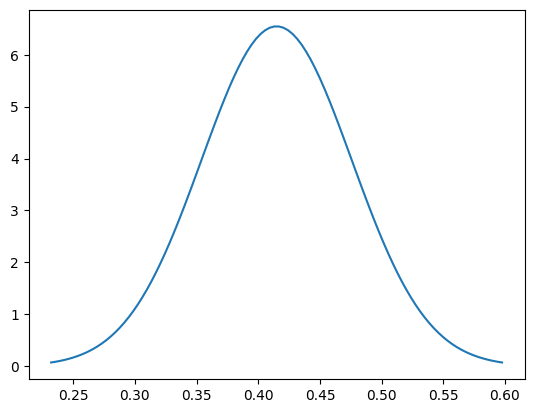

In [22]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import statistics

feature_CC = CC_data[np.random.choice(CC_data.shape[0], 20000, replace=True)]
feature_CC = np.array([arr[:-1] for arr in feature_CC])       
dummyForest = IsolationForest(100, 50, 20, 0.3)
dummyForest.createForest(feature_CC)
test =  CC_data[np.random.choice(CC_data.shape[0], 10000, replace=True)]
anamolyScores = []
for instance in test:
    score = dummyForest.anamolyScore(instance)
    anamolyScores.append(score)
sigma = statistics.stdev(anamolyScores)
mu = statistics.mean(anamolyScores)


anamolyScores = np.array(anamolyScores)
plt.hist(anamolyScores, density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')
plt.show()


stats.probplot(anamolyScores, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()


x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()


<strong>Accuracy</strong>
- Given the testing set, the anamoly scores, a threshold value, the mean of the scores, and the standard deviation of the scores, we can calculate the total accuracy and accuracy of classifying fraudelent instances
- This is done by calculating the z-score of each instance, and if the z-score crosses a certain threshold, we can classify it as fraudelent, else, it is a valid transaction
- In this case, we use a treshold of value -5.2. This was handpicked by us, but we will need to find the optimized threshold value. We will do this when we implement grid search cv to find the best hyperparemeters

In [2]:
def totalAccuracy(test, anamolyScores, threshold, mu, sigma):
    numRight = 0
    for i in range(len(test)):
        z = (anamolyScores[i]- mu) / sigma
        if z<=threshold:
            label = 1
        else:
            label =0
        if int(test[i][-1]) == label:
            numRight+=1
    return numRight/len(test)
print("Percent of correct classification in testing set:")
print(totalAccuracy(test, anamolyScores, -5.2, mu, sigma))


def recall(labels, anamolyScores, threshold, mu, sigma):
    TruePositive = 0
    FalseNegative = 0
    for i in range(len(test)):
        z = (anamolyScores[i]- mu) / sigma
        if z<=threshold:
            label = 1
        else:
            label =0
        if labels[i] == 1:
            TruePositive+=1
        if labels[i]==1 and label==0:
            FalseNegative+=1
    return TruePositive/(TruePositive+FalseNegative)



def fraudAccuracy(test, anamolyScores, threshold, mu, sigma):
    numFraud = 0
    numRight = 0
    for i in range(len(test)):
        if int(test[i][-1]) == 1:
            numFraud+=1
            z = (anamolyScores[i]- mu) / sigma
            if z<=threshold:
                label = 1
            else:
                label =0
            if int(test[i][-1]) == label:
                numRight+=1
    return numRight/numFraud
print("Percent of fraudelent cases caught in a testing set of size 20,000:")
print(fraudAccuracy(test, anamolyScores, -5.2, mu, sigma))

Percent of correct classification in testing set:


NameError: name 'test' is not defined